In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from statsmodels.tsa.arima.model import ARIMAResults

# Data Processing 

In [2]:
sales_data = pd.read_csv('sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
expenses_data = pd.read_csv('expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
print('Shape of expenses data', expenses_data.shape)
print('Shape of sales data', sales_data.shape)
expenses_data

Shape of expenses data (6622, 2)
Shape of sales data (89245, 2)


,expenseAmount,expenseDate
0,15000.0,2020-05-12
1,5500.0,2020-05-12
2,10000.0,2020-05-12
3,12000.0,2020-05-12
4,1400.0,2020-05-12
...,...,...
6617,200.0,2023-11-09
6618,500.0,2023-11-09
6619,6000.0,2023-11-09
6620,11500.0,2023-11-09


In [3]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

In [4]:
# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

In [5]:
def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

In [6]:
def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [7]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

In [8]:
daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [9]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [10]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [11]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category3

In [12]:
category = pd.DataFrame(category)
category.reset_index(inplace=True)
category =category['Amount']

# Detrending

In [13]:
# from scipy.signal import detrend

# category1 = pd.DataFrame(detrend(category))

# Remove Outliers

In [14]:
# category1 = category[(np.abs(stats.zscore(category)) > 3).all(axis=1)]

# Scaling

In [15]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# category = scaler.fit_transform(np.array(category).reshape(-1, 1))

In [16]:
# category = category1

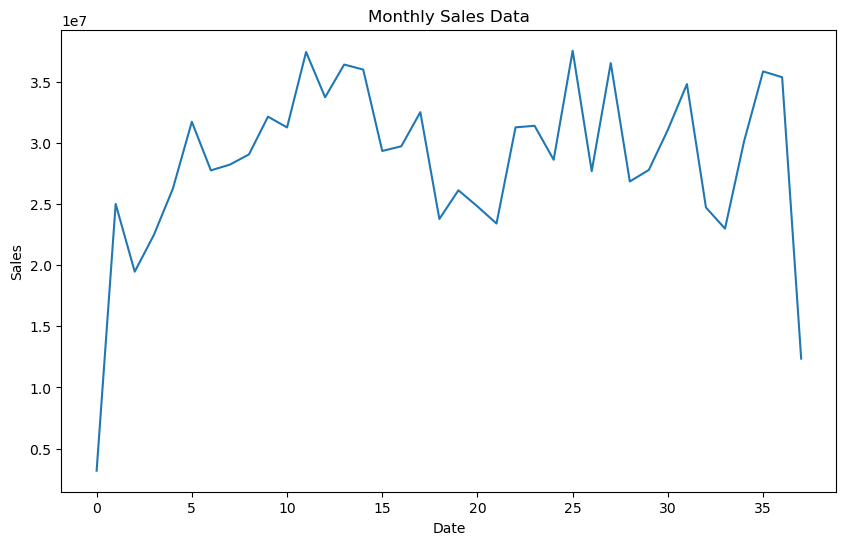

In [17]:
plt.figure(figsize=(10,6))
plt.plot(category)
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [18]:
len(category)

38

In [876]:
# category = category.flatten()
category = pd.DataFrame(category)
category

,Amount
0,3193229
1,24993145
2,19459169
3,22440465
4,26225713
5,31706881
6,27735977
7,28209077
8,29040989
9,32128017


# Train - Test Split

In [877]:
msk = (category.index < len(category) - 4) # The last x data points as test
category_train = category[msk].copy()
category_test = category[~msk]

# Check for Stationarity of time series

ACF Plot and PACF plot

C:\Users\Berlin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


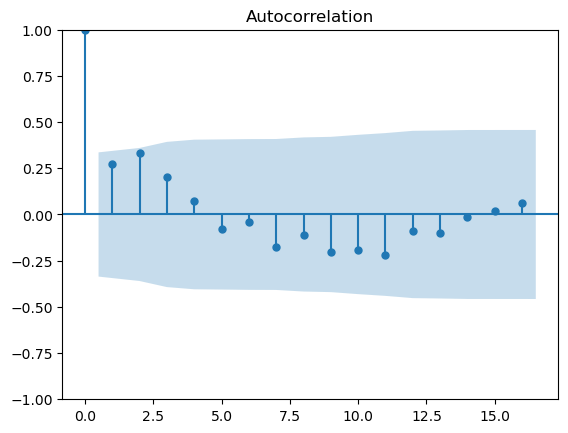

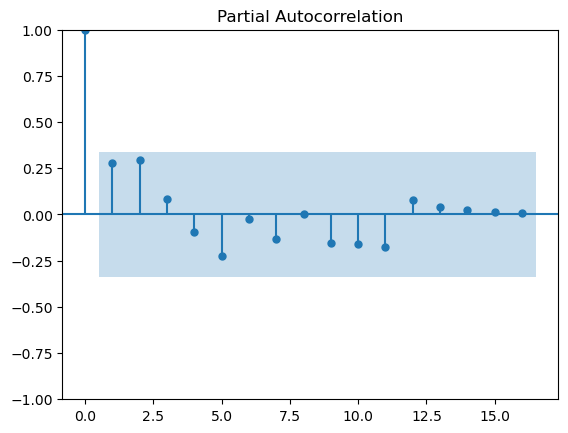

In [878]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(category_train)
pacf_original = plot_pacf(category_train)

ADF Test

In [879]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num of lags : ", dftest[2])
    print("4. Num of observations used for ADF regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

In [880]:
ad_test(category_train)

1. ADF :  -5.98482666057852
2. P-Value :  1.8025618415149028e-07
3. Num of lags :  0
4. Num of observations used for ADF regression and Critical Values Calculation :  33
5. Critical Values : 
	 1% : -3.6461350877925254
	 5% : -2.954126991123355
	 10% : -2.6159676124885216


Differencing

In [881]:
# category1=category1.diff().dropna()

In [882]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

Determine the ARIMA models parameters p,d,q

In [883]:
# Defining the parameters
p=4
d=0
q=1

# Fit the model

In [884]:
# model1=SARIMAX(category_train, order=(p,d,q))
# model2=ARIMA(category_train, order=(23,0,23))
model3=ARIMA(category_train, order=(p,d,q))
# model4=ARIMA(category_train, order=(28,0,28))

In [885]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(model1, f)
# result = model1.fit()
# print(result.summary())

In [886]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(model2, f)
# result = model2.fit()
# print(result.summary())

In [887]:
with open('monthlySales.pk1', 'wb') as f:
    pickle.dump(model3, f)
result = model3.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                   34
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -575.044
Date:                Wed, 27 Mar 2024   AIC                           1164.089
Time:                        14:13:02   BIC                           1174.773
Sample:                             0   HQIC                          1167.733
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.854e+07   1.05e-08   2.73e+15      0.000    2.85e+07    2.85e+07
ar.L1          1.0414      0.119      8.780      0.000       0.809       1.274
ar.L2          0.3227      0.226      1.427      0.1

In [854]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(model4, f)
# result = model4.fit()
# print(result.summary())

# Make Time Series Predictions

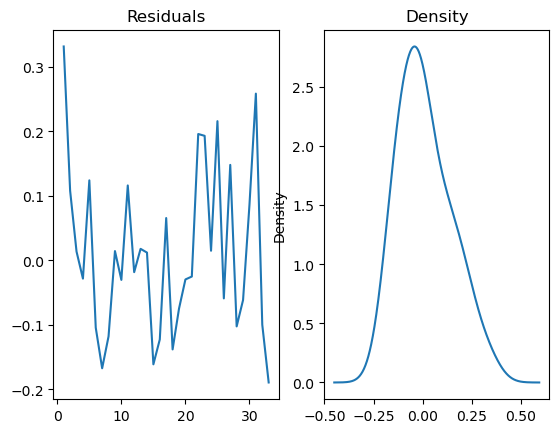

In [855]:
residuals = result.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\Berlin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 16 must be < 16.

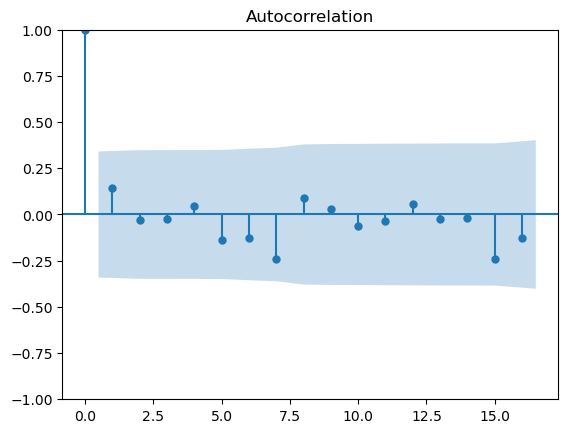

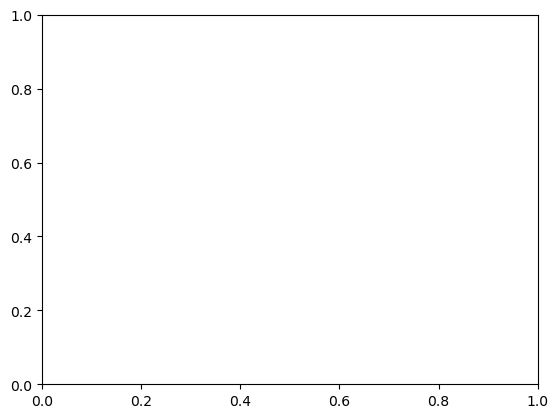

In [856]:
acf_res = plot_acf(residuals)
pacf_residuals = plot_pacf(residuals)

In [857]:
forecast_test = result.forecast(len(category_test))
forecast_test = scaler.inverse_transform(np.array(forecast_test).reshape(-1, 1))
forecast_test
# category1['forecast_manual'] = [None]*len(category1_train) + list(forecast_test)
# category1

array([[25754554.88294813],
       [22471513.38541004],
       [23272616.67205354],
       [23163076.75424861]])

# Evaluate Model

In [858]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(category_test, forecast_test)
mape = mean_absolute_percentage_error(category_test, forecast_test)
rmse =  np.sqrt(mean_squared_error(category_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 23665439.689008303
mape - manual: 42031115.441578984
rmse - manual: 23698146.992155887
